#### library

In [2]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from layers.transformer_encdec import Encoder, EncoderLayer
from layers.selfattention_family import FullAttention, AttentionLayer
from layers.embed import PatchEmbedding

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

2.4.1+cu121
Device: cuda


#### data load

In [3]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [4]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 32.90it/s]


#### data engineering

In [28]:
eda_df = df.loc[df["_type"] == "train"]
eda_test_df = df.loc[df["_type"] == "test"]

In [35]:
interest_col = [col for col in eda_df.columns if 'interest' in col]
price_col = [col for col in eda_df.columns if 'price-ohlcv' in col]
funding_col = [col for col in eda_df.columns if 'funding_rates' in col]
liquidations_col = [col for col in eda_df.columns if '_liquidations' in col]
taker_col = [col for col in eda_df.columns if 'taker' in col]
network_col = [col for col in eda_df.columns if 'network' in col]

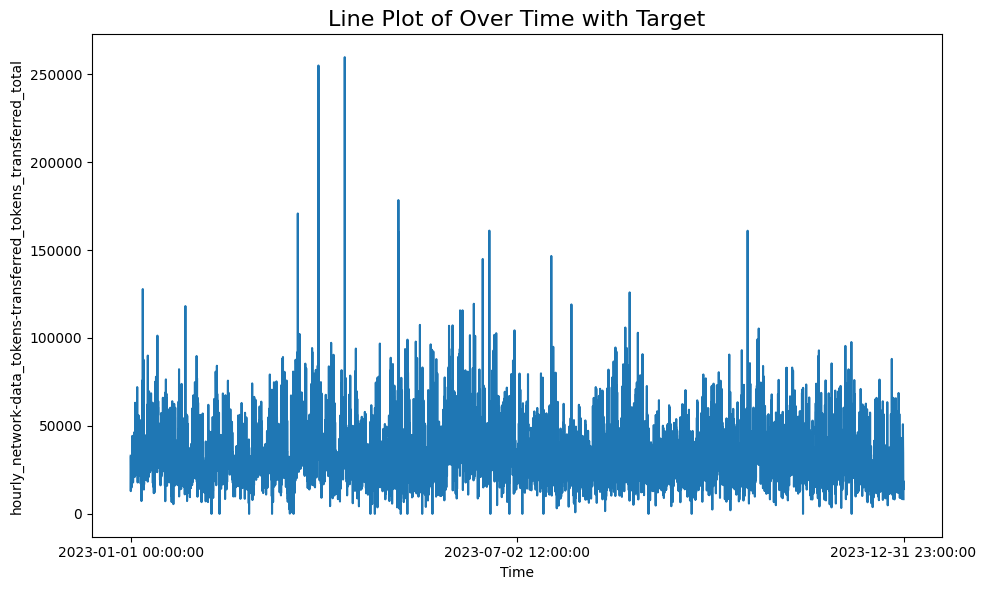

In [26]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=eda_df, x='ID', y='hourly_network-data_tokens-transferred_tokens_transferred_total')
plt.xlabel('Time')
plt.title(f'Line Plot of Over Time with Target', fontsize=16)

# x축에 첨과 끝, 중간 레이블만 표시

first = eda_df['ID'][0]
middle = eda_df['ID'][len(eda_df) // 2]
last = eda_df['ID'][len(eda_df)-1]

xticks = [first, middle, last]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

In [40]:
eda_df[price_col].isnull().sum()
eda_df[liquidations_col].isnull().sum()
eda_df[taker_col].isnull().sum()
eda_df[network_col].isnull().sum()
eda_df[interest_col].isnull().sum()
eda_df[funding_col].isnull().sum()

hourly_market-data_funding-rates_bitmex_funding_rates             1
hourly_market-data_funding-rates_okx_funding_rates                1
hourly_market-data_funding-rates_bybit_funding_rates             31
hourly_market-data_funding-rates_binance_funding_rates            0
hourly_market-data_funding-rates_okex_funding_rates            8760
hourly_market-data_funding-rates_htx_global_funding_rates         4
hourly_market-data_funding-rates_deribit_funding_rates            1
hourly_market-data_funding-rates_all_exchange_funding_rates       0
hourly_market-data_funding-rates_huobi_global_funding_rates      12
dtype: int64

In [41]:
all_col = [col for col in eda_df.columns if 'all_exchange' in col]
all_col

['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume',
 'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
 'hourly_market-data_funding-rates_all_exchange_funding_rates',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio',
 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
 'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd',
 'hourly_market-data_open-inte

In [42]:
eda_df[all_col].isnull().sum()

hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close                       0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume                      0
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest               0
hourly_market-data_funding-rates_all_exchange_funding_rates                          0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume                0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume               0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio                 0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio                0
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio            0
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations            0
hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations           0
hourly_market-data_liquidations_all_exchang